# Exploring SMHI open data using Python

Meteorological observations in Sweden are available from SMHI trough a public API. 
https://opendata.smhi.se/apidocs/metobs/index.html This includes temperature, rainfall etc.
As an excersice one can explore this using Python...


## Available parameters


In [6]:
import requests

#Entry point in SMHI api to list parameters
href = 'https://opendata-download-metobs.smhi.se/api/version/latest/parameter.json'
r = requests.get(href).json()

#Format output
print('{: <5}{: <40}{: <20}'.format('KEY', 'TITLE', 'SUMMARY'))
for resource in r['resource']:
    print('{: <5}{: <40}{: <20}'.format(resource['key'],resource['title'], resource['summary']))

KEY  TITLE                                   SUMMARY             
21   Byvind                                  max, 1 gång/tim     
11   Global Irradians (svenska stationer)    medelvärde 1 timme, 1 gång/tim
22   Lufttemperatur                          medel, 1 gång per månad
19   Lufttemperatur                          min, 1 gång per dygn
1    Lufttemperatur                          momentanvärde, 1 gång/tim
2    Lufttemperatur                          medelvärde 1 dygn, 1 gång/dygn, kl 00
20   Lufttemperatur                          max, 1 gång per dygn
9    Lufttryck reducerat havsytans nivå      vid havsytans nivå, momentanvärde, 1 gång/tim
24   Långvågs-Irradians                      Långvågsstrålning, medel 1 timme, varje timme
17   Nederbörd                               2 gånger/dygn, kl 06 och 18
18   Nederbörd                               1 gång/dygn, kl 18  
15   Nederbördsintensitet                    max under 15 min, 4 gånger/tim
23   Nederbördsmängd                    

## List updated stations

Looking at parameter 1 which is temperature recorded per hour we can and list all available stations that were updated during the last week.

In [7]:
import datetime as dt

def print_station(s):
    """helper function to format printing"""
    name = s['name']
    updated = dt.datetime.fromtimestamp(s['updated']/1e3)
    updated_str = updated.strftime('%Y-%m-%d')
    print('{: <40} {: <20}'.format(name, updated_str))    

    
#List all stations with parameter 1
href = 'https://opendata-download-metobs.smhi.se/api/version/latest/parameter/1/station.json'
r = requests.get(href).json()

#time threshold for filering out not updated stations
threshold = dt.datetime.now()-dt.timedelta(days=7)

stations = []
for s in r['station']:
    #Get timestamp. Divide with 1e3 to go from ms to s
    updated = dt.datetime.fromtimestamp(s['updated']/1e3)
    if updated>threshold:
        stations.append(s)

#Print the 5 first and 3 last stations
print('{: <40}{: <20}'.format('AVAILABLE STATIONS','LATEST UPDATED'))
for s in stations[0:5]:
    print_station(s)
print('...')
for s in stations[-3:-1]:
    print_station(s)
print('TOTAL: {:d}'.format(len(stations)))
        
#Search stations by name
print('\nSelected stations')
names = ['Sundsvall', 'Idre']
selected_stations = []
print('{: <40}{: <20}'.format('NAME', 'KEY'))
for s in stations:
    for n in names:
        if n in s['name']:
            print('{: <40}{: <20}'.format(s['name'], s['key']))
            selected_stations.append(s)

AVAILABLE STATIONS                      LATEST UPDATED      
Adelsö A                                 2017-11-29          
Arjeplog A                               2017-11-29          
Arvidsjaur A                             2017-11-29          
Arvika A                                 2017-11-29          
Avesta                                   2017-11-29          
...
Östmark-Åsarna                           2017-11-29          
Överkalix-Svartbyn A                     2017-11-29          
TOTAL: 242

Selected stations
NAME                                    KEY                 
Idre Fjäll A                            112540              
Sundsvalls Flygplats                    127310              


# Plot the temperature the last 24 hours

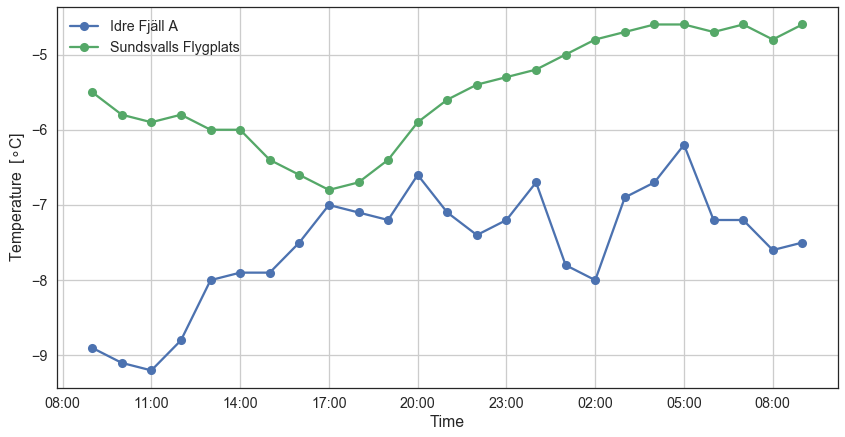

In [8]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_context('talk', font_scale = 1.1)
sns.set_style('white')

href = 'https://opendata-download-metobs.smhi.se/api/version/latest/parameter/1/station/{:s}/period/latest-day/data.json'

fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(111)
for s in selected_stations:
    r = requests.get(href.format(s['key'])).json()
    y  = [ float(v['value']) for v in r['value']]
    x = [dt.datetime.fromtimestamp(v['date']/1e3) for v in r['value']]
    ax.plot(x,y, 'o-', label=s['name'])
plt.legend()
myFmt = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(myFmt)
ax.set_xlabel('Time')
ax.set_ylabel('Temperature  [$\circ$C]')
ax.grid(True)
plt.show()